# FTS simulations

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline  
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [14, 10]

# Setup

We'll first define the shape of the bandpass, the frequency range, and the details of the FTS.  From these we'll simulate an interferogram, where x=0 corresponds to the white light fringe.

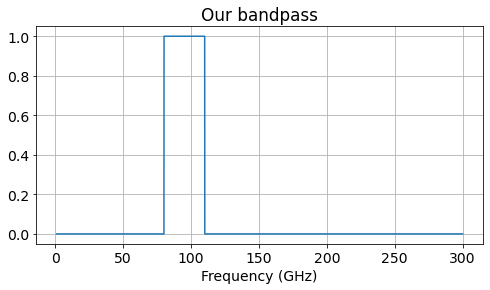

In [249]:
# FTS setup details
#  We're going to work in units of mm here, and GHz.
c = 3e8

xmax = 0.1 # meters
xmin = -0.07 #meters
dx = 0.01e-3  # meters

xvec = np.arange(xmin,xmax,dx)

# set up the bandpass;  note that we're making no attempt to synchronize this 
# with the FTS frequency-space sampling!
numin = 1.     # GHz
numax = 300.
nuvec = np.linspace(numin,numax,10000)
lamvec = (c/(nuvec*1e9))   # multiply by 0.001 to convert from meters to mm.

# Square bandpass
bandvec = np.where( ((nuvec>80)&(nuvec<110)), 1, 0)

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(nuvec,bandvec)
plt.xlabel('Frequency (GHz)')
plt.title('Our bandpass')
plt.grid()

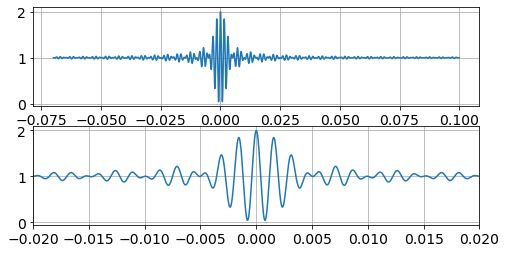

In [250]:
# Make an interferogram;
# at every frequency, the intensity at the output of the FTS is
# proportional to [cos(2*pi*(2x)/lambda)]^2, where x is the mirror offset from 0 path differnece.
I = np.zeros(len(xvec))
E1 = np.ones(len(nuvec))*np.sqrt(bandvec)
E2 = np.ones(len(nuvec))*np.sqrt(bandvec)


for ii in range(len(lamvec)):
    I = I + E1[ii]*E1[ii] + E2[ii]*E2[ii] +2* E1[ii]*E2[ii]*np.cos(2*np.pi*2*xvec/lamvec[ii])

endsize = int(len(xvec)/10)
I = I/np.mean(np.append(I[0:endsize],I[-endsize:]))

plt.subplot(2,1,1)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(xvec,I)
#plt.xlim(-0.02,0.02)
plt.grid()

plt.subplot(2,1,2)
plt.plot(xvec,I)
plt.xlim(-0.02,0.02)
plt.grid()

# Turn that into a timestream 
by using the the mirror velocity

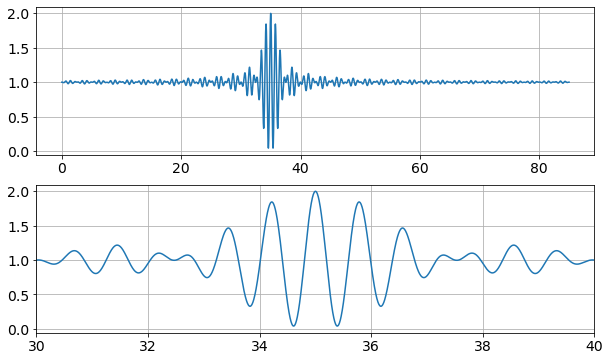

In [251]:
v_mirror = 2.e-3 #meters/sec
tvec = (xvec-xvec[0])/v_mirror

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [10, 6]
plt.subplot(2,1,1)
plt.plot(tvec,I)
#plt.xlim(-20,20)
plt.grid()

plt.subplot(2,1,2)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(tvec,I)
plt.xlim(30,40)
plt.grid()

# Interferogram -> Band
Let's now pretend we just took that interferogram, and all we know is the timing of the samples and the signal level (ie the intensity).  How do we get back the band shape?

There are several approaches:

 - Just take the psd, and plot it.  (This rectifies noise).
 - Find the white-light fringe, center up on it, and:
  - take the Fourier Transform and use only the real part.  The imaginary part serves as a diagnostic and a noise estimate.
  - average the two halves (symmetrize it), do a FT and use only the real part.  
  
In all cases we need to make a frequency (GHz) axis out of the timestream sampling rate and the mirror velocities.  In a time $\Delta t$ the mirror moves a distance $\Delta x = v \Delta t$.  The optical path length change in the moving-mirror arm is $D = 2 \Delta x = 2 v \Delta t$.  

The wavelength that undergoes one oscillation of interference intensity (constructive to destructive to constructive again, say) is $\lambda = D = 2v\Delta t$.  We can substitute $\lambda = c/\nu$, and solve for the time it takes for photons at a given frequency to go through one cycle of "constructive to destructive and back to constructive" interference, as

$$ \Delta t = \frac{c}{2 \nu v} .$$

Inverting this tells us the (audio) frequency of the signal associated with a given photon frequency,

$$ f(\nu) = \frac{2 \nu v}{c} \ \mbox{Hz}. $$

Therefore, the photon frequency is

$$ \nu = \frac{f c}{2 v} , $$

where $\nu$ is the photon frequency, and $v$ is the moving mirror velocity.

There are two important things slightly hidden in this discussion.  First, there is a longest photon wavelength that will go from constructive interference, to destructive, back to constructive in the total distance the mirror moves away from the white light fringe (on one side).  That longest wavelength is 

$$ \lambda_{max} = 2 v \Delta t = 2 \Delta x_{max}$$

where $\Delta x_{max}$ is that total distance moved away from the white light fringe.  This also tells us the lowest frequency we can resolve, and the frequency resolution,

$$ \nu_{min} = \Delta \nu = c/\lambda_{max} = \frac{c}{2 \Delta x_{max}} .$$

Similarly, given our timestream sampling interval (which will be introduced below), 
there is a shortest wavelength we can observe related to the timestream sampling
interval.  (In practice other things may limit this too, but it sets the upper limit
on the photon-frequency axes we can plot later).  We'll worry more about that later, just be aware of that fact for now.

# PSD version

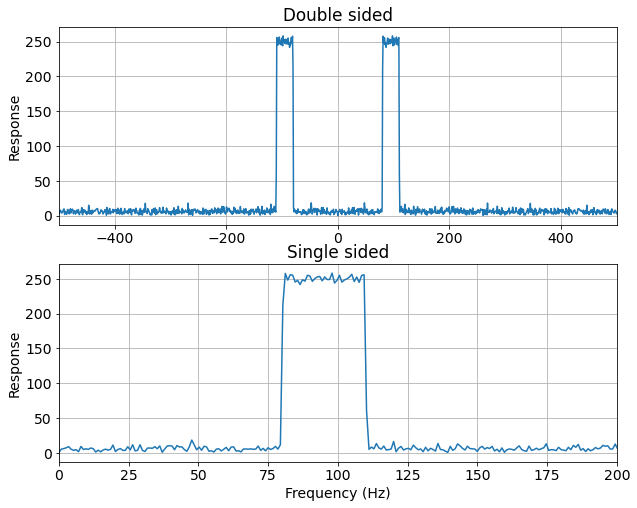

In [252]:
def fftshifted_twosided(signal,dt):
    freqvec_out = np.fft.fftshift(np.fft.fftfreq(len(signal),dt))  # audio freq vector
    fft_out = np.fft.fftshift(np.fft.fft(signal-np.mean(signal)))
    return freqvec_out, fft_out

def fftshifted_onesided(signal,dt):
    freq,fft_2 = fftshifted_twosided(signal,dt)
    ii_pos = np.where(freq>=0)
    freq_pos = freq[ii_pos]
    fft_pos = fft_2[ii_pos]
    return freq_pos, fft_pos
    
def psd_twosided(signal,dt):
    '''
    Returns the two-sided PSD and appropriate frequency vector.
    The signal is mean-subtracted before the psd is calculated.
    '''

    freqvec_out, fft_out = fftshifted_twosided(signal, dt)   # audio freq vector
    psd_out = np.abs(fft_out)

    return freqvec_out, psd_out
    # band response (psd)
    
def psd_onesided(signal,dt):
    '''
    Returns the one-sided PSD and appropriate frequency vector.
    The signal is mean-subtracted before the psd is calculated.
    '''
    freq,psd2 = psd_twosided(signal,dt)
    ii_pos = np.where(freq>=0)
    freq_pos = freq[ii_pos]
    psd_pos = psd2[ii_pos]
    
    return freq_pos, psd_pos
    

# let's add some noise to I first
noise = 0.05*np.random.randn(len(xvec))
signal = I+noise

dt = tvec_out[1]-tvec_out[0]
freqvec,psdvec = psd_twosided(signal,dt)
nuvec_out = freqvec*c/(2*v_mirror)  # photon freq vector

freqvec1,psdvec1 = psd_onesided(signal,dt)
nuvec1_out = freqvec1*c/(2*v_mirror)  # photon freq vector


plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [10, 8]
plt.clf()

plt.subplot(2,1,1)
plt.plot(nuvec_out/1e9,psdvec)
plt.ylabel('Response')
plt.xlim(-500,500)
plt.title('Double sided')
plt.grid()
#
plt.subplot(2,1,2)
plt.plot(nuvec1_out/1e9,psdvec1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response')
plt.title('Single sided')
plt.xlim(0,200)
plt.grid()


# One side of the interferogram, FFT_real

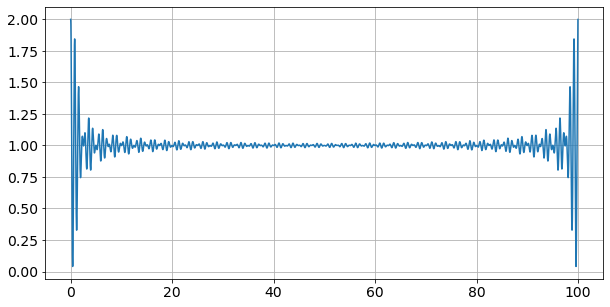

In [253]:
# Find the white light fringe, 
# We'll do the easy thing;  
#   with noisy data you may have to do something more complicated,
#   like fit to a range of points.
#
# Then take only the data *after* the white light fringe, 
# and add a flipped copy before taking the FT.

def I_aftermax(I):
    max_index = np.where((I == np.max(I)))[0][0]
    I_cut = I[max_index:]
    return I_cut

Inew = I_aftermax(I)
tnew = np.arange(0,len(Inew)*dt,dt)

Iflipped = np.flip(Inew[1:])

Itot = np.concatenate([Inew,Iflipped])
t_tot = np.arange(0,len(Itot)*dt,dt)

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(t_tot, Itot)
#plt.xlim(48,52)
plt.grid()

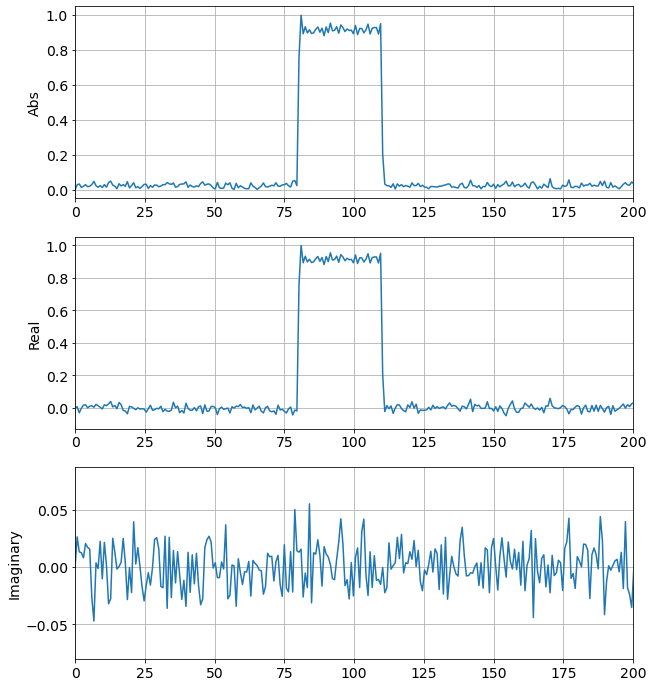

In [254]:
# let's add some noise to I first
noise = 0.05*np.random.randn(len(Itot))
signal = Itot+noise

freqvec1a,ffta = fftshifted_onesided(signal,dt)

ffta_abs = np.abs(ffta)
fftmax = np.max(ffta_abs)
ffta_abs = ffta_abs/fftmax
ffta_real = np.real(ffta)/fftmax
ffta_imag = np.imag(ffta)/fftmax

nuvec1a_out = freqvec1a*c/(2*v_mirror)  # photon freq vector


plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [10, 12]
plt.clf()

fmax = 200
plt.subplot(3,1,1)
plt.plot(nuvec1a_out/1e9,ffta_abs)
plt.ylabel('Abs')
plt.xlim(0,fmax)
plt.grid()
#
plt.subplot(3,1,2)
plt.plot(nuvec1a_out/1e9,ffta_real)
plt.ylabel('Real')
plt.xlim(0,fmax)
plt.grid()
#
plt.subplot(3,1,3)
plt.plot(nuvec1a_out/1e9,ffta_imag)
plt.ylabel('Imaginary')
plt.xlim(0,fmax)
plt.grid()

# Some things relevant to band measurements

99.99500000000512
100.66200000000545


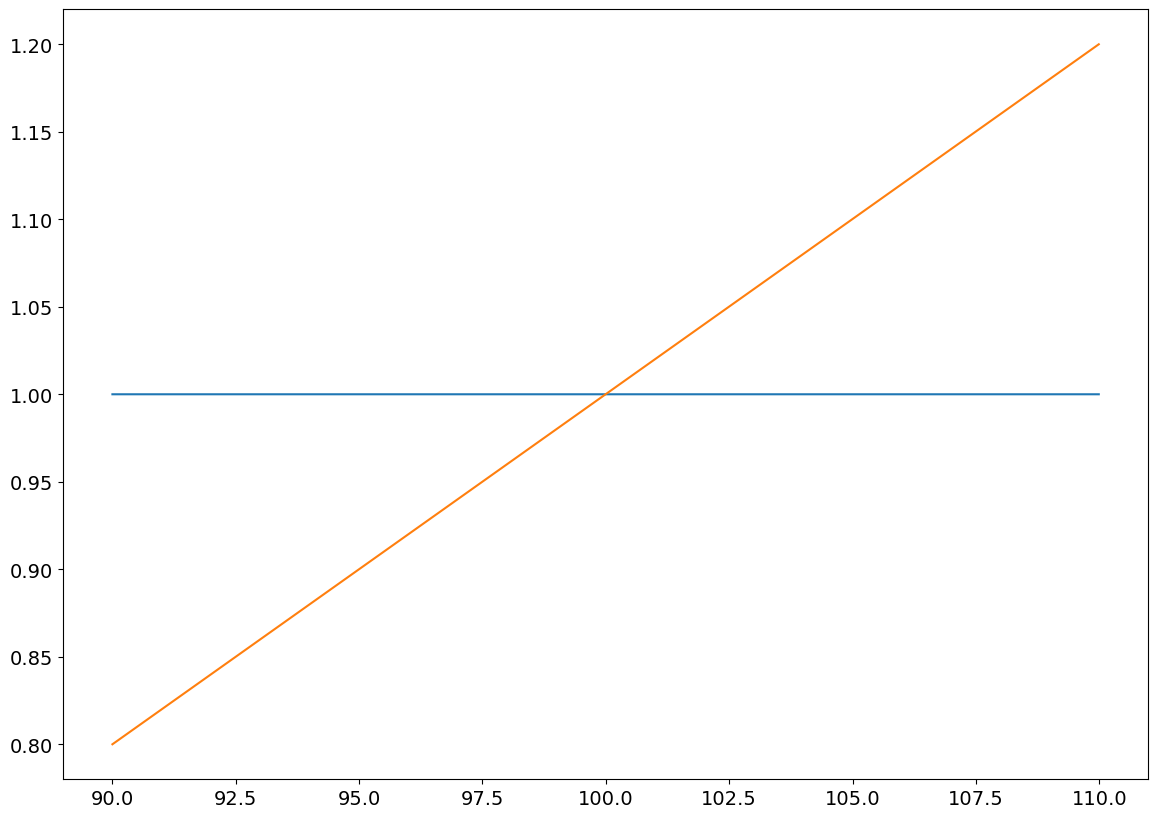

In [8]:
# How flat does instrument*source response have to be to keep band centers from being biased?

freqs = np.arange(90,110,0.01)
band = np.ones(len(freqs))
gain_sloped = np.linspace(-0.2,0.2,len(band))

measband = band*(1+gain_sloped)
plt.plot(freqs,band)
plt.plot(freqs,measband)

print(np.mean(freqs*band))
print(np.mean(freqs*measband))